**Module Path**

In [1]:
import os

os.chdir("./../../")

**Device**

In [2]:
from utils import get_device
from examples.gridworld.utils import preprocess, preprocess_batch

device = get_device()

In [3]:
import numpy as np
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use("ggplot")
np.set_printoptions(precision=3, linewidth=120)

is_ipython = "inline" in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

---

## Explore GridWorld

We begin by importing the necessary packages.

In [4]:
from env import MLAgents

In [5]:
env = MLAgents("GridWorld")

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [6]:
print(env.get_observation_space())
print(env.get_action_space())

[ObservationSpec(shape=(3, 64, 84), dimension_property=(<DimensionProperty.NONE: 1>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>, <DimensionProperty.TRANSLATIONAL_EQUIVARIANCE: 2>), observation_type=<ObservationType.DEFAULT: 0>, name='RenderTextureSensor'), ObservationSpec(shape=(2,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.GOAL_SIGNAL: 1>, name='VectorlSensor')]
Continuous: 0, Discrete: (5,)


- **0**: Stay in place
- **1**: Move up
- **2**: Move down
- **3**: Move left
- **4**: Move right

In [7]:
env.env.reset()
decision_steps, terminal_steps = env.env.get_steps(env.behavior_name)

In [8]:
terminal_steps

In [9]:
n, m, v1, v2 = decision_steps.obs[0].shape
n, m, v1, v2

(9, 3, 64, 84)

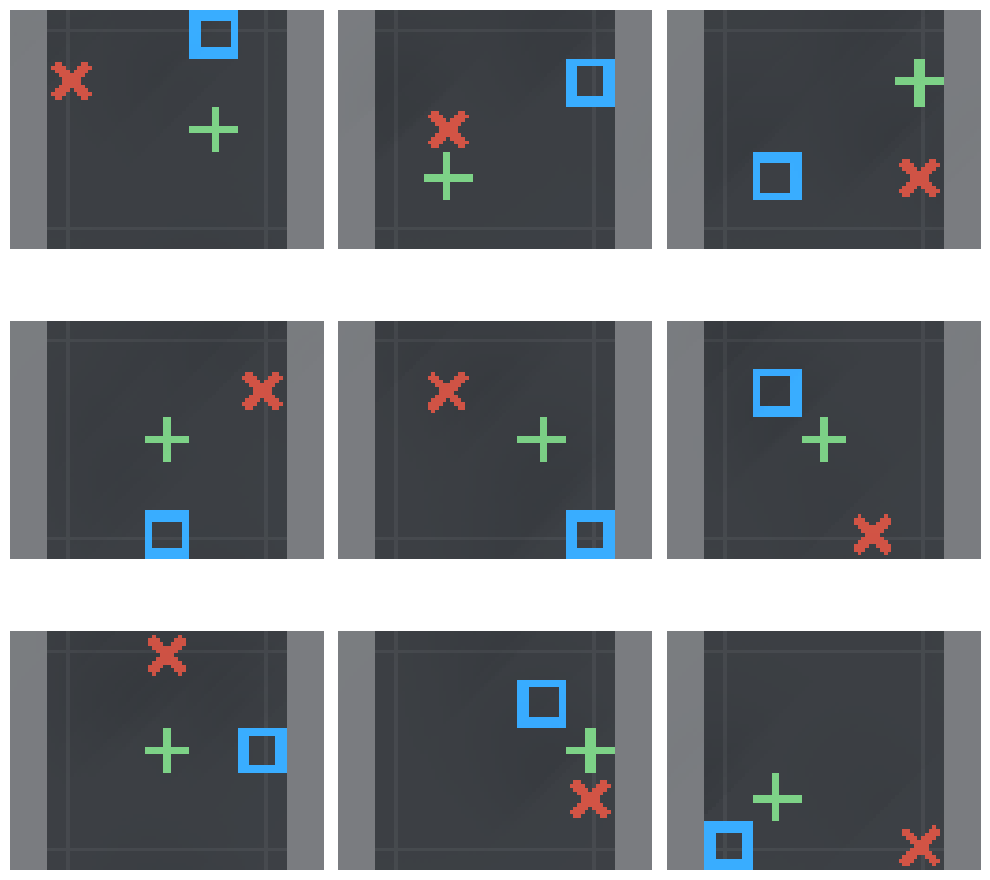

In [10]:
import numpy as np
import matplotlib.pyplot as plt

env.env.reset()

action_space = env.get_action_space()
action = action_space.random_action(len(decision_steps))
env.env.set_actions(env.behavior_name, action)
env.env.step()

decision_steps, terminal_steps = env.env.get_steps(env.behavior_name)

# Assuming images are in the format (batch_size, channels, height, width)
images = decision_steps.obs[0]

# Define number of rows and columns for the grid display
rows = 3  # 3x3 grid for 9 images
cols = 3

# Create a figure for displaying RGB images
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))  # Adjust size as needed

# Loop through each image batch and place it in the grid
for i in range(rows):
    for j in range(cols):
        batch_index = i * cols + j
        if batch_index < n:
            # Transpose each image to (height, width, channels) for RGB display
            axes[i, j].imshow(images[batch_index].transpose(1, 2, 0))
            axes[i, j].axis("off")  # Turn off axis for clarity

plt.tight_layout()
plt.show()

Average Score:  -0.0966666645059983


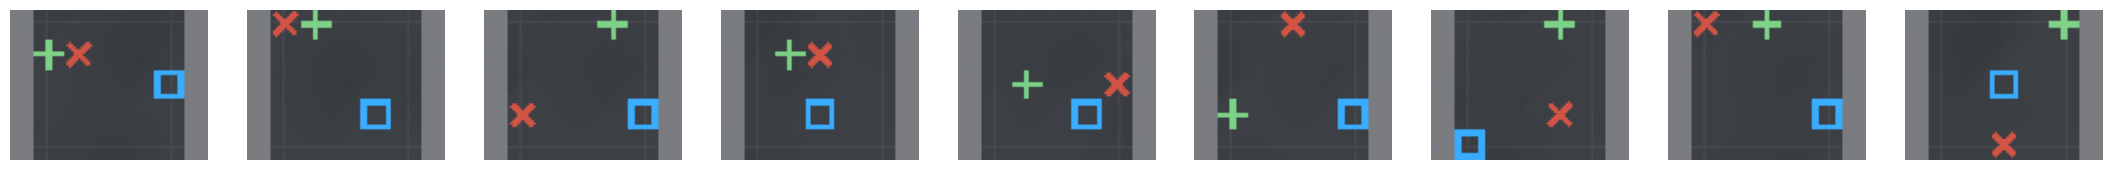

In [11]:
from policy import RandomPolicy

random_policy = RandomPolicy(env.get_action_space())
env.watch(random_policy, display, steps=10)

## Preprocessing

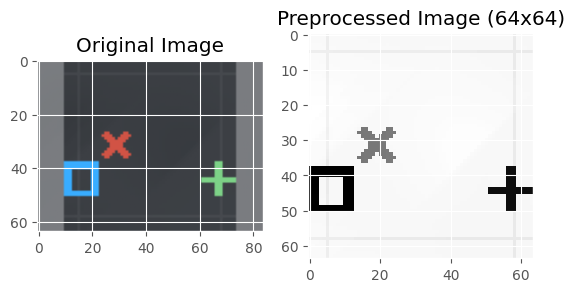

In [12]:
# Reset environment and get the initial state
state = env.reset()[0]
# Assume `n` is defined for the action space
for _ in range(20):
    action = env.get_action_space().random_action(n)
    frames, _, _, _, _ = env.step(action)

frame = frames[0]

# Display the original frame (assuming we take the first frame from the batch)
plt.subplot(1, 2, 1)
plt.imshow(frame.transpose(1, 2, 0))  # Transpose to HWC for display
plt.title("Original Image")


# Preprocess the batch and display a preprocessed image
preprocessed_frame = preprocess(frame)
preprocessed_frame = (
    preprocessed_frame.cpu().numpy().squeeze()
)  # Take first image in the batch
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_frame, cmap="Greys")
plt.title("Preprocessed Image (64x64)")

plt.show()

## Model

In [13]:
from model import FCBody, Conv2DBody
import torch.nn as nn

in_channels = 1
h_channels = 4
out_channels = 16
kernel_size = 6
h_stride = 2
a_stride = 4
h_activation = nn.ReLU()
a_activation = nn.ReLU()
h_bias = False
a_bias = True

state_size = out_channels * 7 * 7
hidden_size = 256
action_size = env.get_action_space().discrete_branches[0]


class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # input 40x40x2
        self.conv2dBody = Conv2DBody(
            in_channels=in_channels,
            h_channels=h_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            a_stride=a_stride,
            h_stride=h_stride,
            h_activation=h_activation,
            a_activation=a_activation,
            h_bias=h_bias,
            a_bias=a_bias,
        )
        self.fcBody = FCBody(
            s_size=state_size,
            a_size=action_size,
            h_size=hidden_size,
            h_activation=nn.ReLU(),
            a_activation=nn.Softmax(dim=-1),
        )

    def forward(self, state):
        x = self.conv2dBody(state)
        x = self.fcBody(x)
        return x


model = Model().to(device)

## Policy

In [14]:
from policy import ReinforcePolicy

policy = ReinforcePolicy(model=model, device=device)

## Train

In [15]:
import torch.optim as optim
from train import ReinforceTrainer
from torch.optim.lr_scheduler import StepLR

max_steps_per_episode = 25
gamma = 0.99
print_every = 100
target_score = 0.8
n_episodes = 1_000

lr = 1e-2
lr_decay_step_size = 500
lr_decay = 0.99

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=lr_decay_step_size, gamma=lr_decay)

trainer = ReinforceTrainer(
    policy,
    env,
    optimizer,
    scheduler=scheduler,
    max_steps_per_episode=max_steps_per_episode,
    gamma=gamma,
    target_score=target_score,
    print_every=print_every,
)

In [16]:
scores = trainer.train(
    n_episodes,
    future_rewards_only=True,
    normalize_rewards=True,
    preprocess_state_fn=preprocess_batch
)

Episode 100	Average Score: -0.25	Learning Rate: 0.010000


Episode 200	Average Score: -0.25	Learning Rate: 0.010000


Episode 300	Average Score: -0.25	Learning Rate: 0.010000


Episode 400	Average Score: -0.25	Learning Rate: 0.010000


Episode 500	Average Score: -0.25	Learning Rate: 0.009900


Episode 600	Average Score: -0.25	Learning Rate: 0.009900


Episode 700	Average Score: -0.25	Learning Rate: 0.009900


Episode 800	Average Score: -0.25	Learning Rate: 0.009900


Episode 900	Average Score: -0.25	Learning Rate: 0.009900


Episode 1000	Average Score: -0.25	Learning Rate: 0.009801


In [17]:
trainer.evaluate(5, preprocess_state_fn=preprocess_batch)

Evaluation: Average reward over 5 episodes: [-0.248 -0.25  -0.248 -0.248 -0.244 -0.246 -0.244 -0.25  -0.248]


array([-0.248, -0.25 , -0.248, -0.248, -0.244, -0.246, -0.244, -0.25 , -0.248])

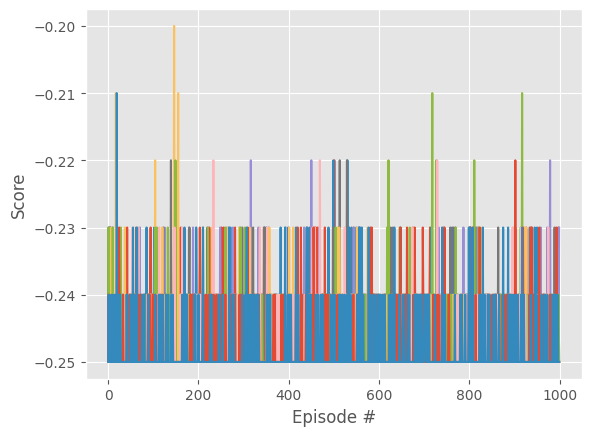

In [18]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel("Score")
plt.xlabel("Episode #")
plt.show()

## Save the agent

In [19]:
import torch

# Define the path where you want to save the model
model_path = "./checkpoints/reinforce_policy_gridworld.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

## Watch a Smart Agent

Average Score:  -0.09888888667854998


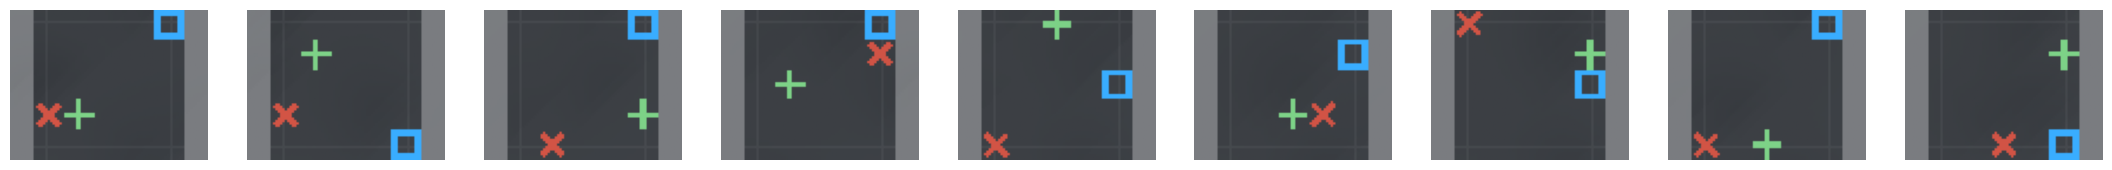

In [20]:
env.watch(policy, display, steps=10, preprocess_state_fn=preprocess_batch)